# HW4

We recommend [`PyTorch`](https://pytorch.org/get-started/locally/) when building your models. If you are more familiar with [`TensorFlow`](https://www.tensorflow.org/install), it's also fine.

### If you have no experience with installing packages, try to use `Google Colab` (which has PyTorch pre-installed).

### To install PyTorch on your local machine:

1. Create a new environment to install PyTorch. (If you did something wrong, it's easy to delete and create a new one.)
2. Open the installation page of PyTorch (https://pytorch.org/get-started/locally/).
3. Select the stable version of PyTorch, with corresponding OS.
4. For Package, it's recommended to use `Conda` or `pip`.
5. Select the corresponding CUDA or CPU version.
6. Run the command in your terminal to install PyTorch.

# Question 1 - Neural Networks

we first load the dataset and show some images to let you get some sense of the data.

In [11]:
import os
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.transforms as transforms

from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('You can learn how to use GPU if you have cuda enabled\n')

Using device: cpu
You can learn how to use GPU if you have cuda enabled



In [58]:
class HandImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.classes = sorted(self.img_labels.iloc[:, 1].unique())
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image.permute(1, 2, 0).numpy())
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [61]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert the image to a PIL Image
    transforms.Grayscale(num_output_channels=1),  # Convert the image to grayscale (1 channel)
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the data to have mean 0 and std 1
])

# Load Fashion MNIST dataset
trainset = HandImageDataset(
    annotations_file='C:/code/ECSE4840/Fun Stuff/#rdi/data.csv',
    img_dir='C:/code/ECSE4840/Fun Stuff/#rdi',
    transform=transform
)

testset = HandImageDataset(
    annotations_file='C:/code/ECSE4840/Fun Stuff/#rdi/data.csv',
    img_dir='C:/code/ECSE4840/Fun Stuff/#rdi',
    transform=transform
)

sample_image, sample_label = trainset[0]

print(f'trainset.data.shape: {sample_image.numpy().shape}') #\ntestset.data.shape: {testset.data.shape}')
classes = trainset.classes
print(f'classes: {len(classes)}')

trainset.data.shape: (1, 224, 224)
classes: 7


torch.Size([64, 1, 224, 224])


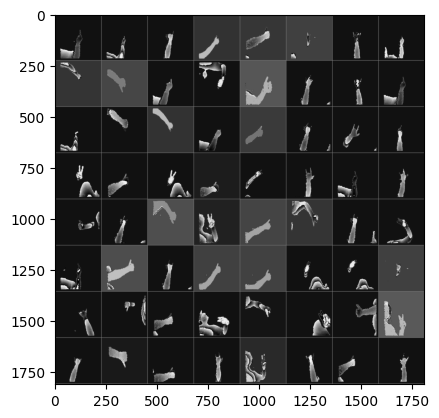

In [51]:
# Create data loaders
batch_size = 64 # modify if necessary
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))

#### Now we have the data ready. Next is to build and train models. 
Below are two turorials that's very helpful to get you started with PyTorch.

1. [How to build models](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html)
2. [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

It's recommended to read through them before you start.
Some points to note:
1. Examples to build MLP and CNN.
2. The usage of `DataLoader`.
3. How to train a model.

## 1. (a) MLP

# STUDENT ANSWER: 

I observed that the training process for this MLP was relatively quick, and reached a constant loss quickly with the provided hyperparameters and MLP structure. That being said, this loss was relatively high and indicates an error with overfitting of the MLP. This is evident in the confusion matrix where a T-shirt is confused for a regular shirt; and can be a reason for the relatively low training accuracy and testing accuracy performance. The testing accuracy was slightly lower than the training accuracy, which is expected since the data has never been seen before.

start by building a simple MLP with the requried structure.

Hint: 

You need to flatten the image to feed it into the MLP.

You don't need to add softmax in the last layer, `CrossEntropyLoss` will do that for you later.

In [ ]:
##################################
##  TODO: Complete this cell
##################################

import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        ## TODO: define your layers here
        self.flatten = nn.Flatten()
        # Start with 64 neurons in the first hidden layer that use ReLU activation function
        self.l1 = nn.Linear(224*224, 2048)
        self.l2 = nn.Linear(2048, 2048)
        self.l3 = nn.Linear(2048, 512)

        self.l4 = nn.Linear(512, 64)
        self.relu = nn.ReLU()
        # Output layer should have 10 neurons (one for each class) and use softmax activation function
        self.l5 = nn.Linear(64, 7)
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x):
        ## TODO: define the forward pass
        x = self.flatten(x)
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.l4(x)
        x = self.relu(x)
        x = self.l5(x)
        x = self.softmax(x)
        return x

#### Training. We ask you to complete this in a function for reuse

In [65]:
##################################
##  TODO: Complete this cell
##################################

import torch.optim as optim
import scipy.signal
from datetime import datetime

## load your model
model = MLP().to(device)

## parameters that can be tuned
batch_size = 64
learning_rate = 0.02
num_epochs = 20

## necessary initializations
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
criterion = nn.CrossEntropyLoss() ## TODO: define the loss function
optimizer = optim.Adam(model.parameters(), lr = learning_rate) ## TODO: define the optimizer


def train_model(model, trainloader, criterion, optimizer, num_epochs=3):
    """Train a neural network model on the given dataset.
    
    Inputs:
        model (torch.nn.Module): The neural network model to train
        trainloader (torch.utils.data.DataLoader): Training data loader
        criterion (torch.nn.Module): Loss function
        optimizer (torch.optim.Optimizer): Optimizer
        num_epochs (int, optional): Number of training epochs. Defaults to 3
    
    Outputs:
        train_losses: a list, history of losses
    """
    # Track loss history
    train_losses = []
    
    # Set model to training mode
    model.train()

    # Start timing
    start_time = datetime.now()
    last_loss = 0.0
    
    for epoch in range(num_epochs):
        ## TODO: complete the training loop
        ## you need to move data to device if you use GPU
        running_loss = 0.0
        i = 0

        for inputs, labels in trainloader:
            # Get inputs and labels, move to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track stastics
            running_loss += loss.item()

            # Print statistics every 100 mini-batches
            if i % 100 == 99:
                print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/100}')
                running_loss = 0

            train_losses.append(loss.item())
            i += 1
    
    # Print total training time
    total_time = datetime.now() - start_time
    print(f'Finished Training. Total time: {total_time}')

    train_losses = scipy.signal.savgol_filter(train_losses, 51, 3)
    return train_losses

Finished Training. Total time: 0:02:22.999559


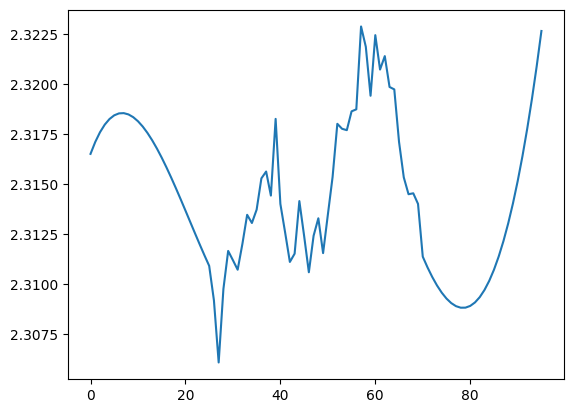

In [66]:
## train the model
mlp_losses = train_model(model, trainloader, criterion, optimizer, num_epochs=3)
plt.plot(mlp_losses)
plt.show()

#### Evaluate the model

Accuracy on train set: 0.1494


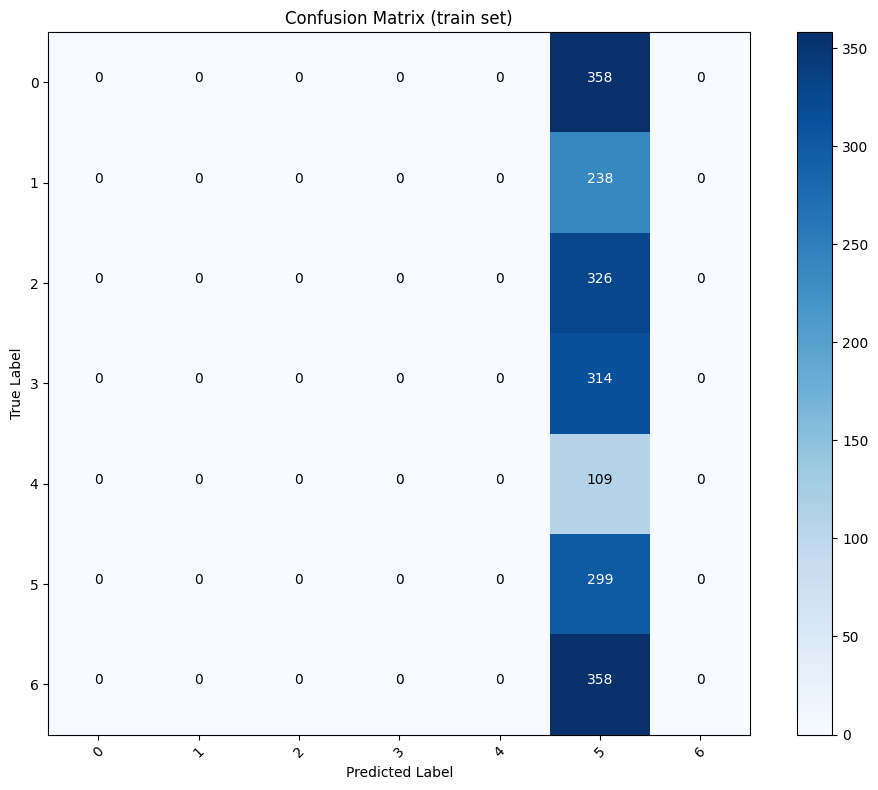

Accuracy on test set: 0.1494


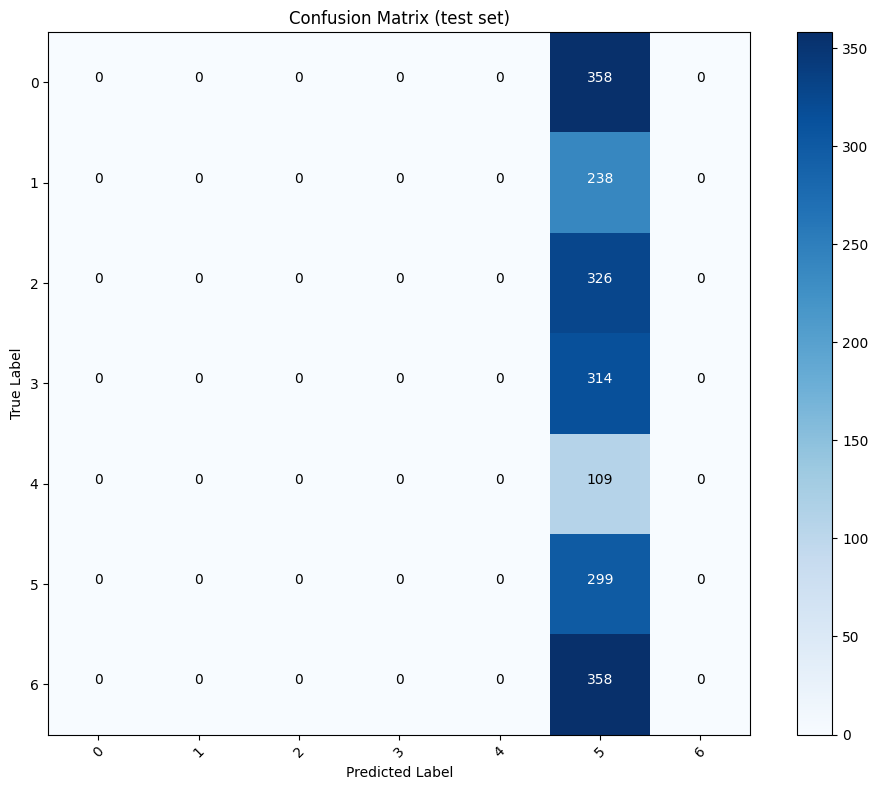

In [67]:
#################################
## This is the cell for checking
## Do NOT edit this cell
#################################

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, device, name="test"):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy on {name} set: {accuracy:.4f}')
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name} set)')
    
    # Add colorbar
    plt.colorbar()
    
    # Add labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add numbers to cells
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return accuracy, cm

train_acc, train_cm = evaluate_model(model, trainloader, device, "train")
test_acc, test_cm = evaluate_model(model, testloader, device, "test")

## 1. (b) Fine-tune the model

# STUDENT ANSWER: 

I observed that the training process for this MLP was signifcantly longer than the first MLP, which can be attributed to the larger neural network and increased number of epochs (3 to 20). This MLP reached a constant loss after a couple of epochs, and looked to be suffering less from overfitting. The loss for this MLP was much lower than the MLP in part (a). Overall accuracy was outstanding, landing in the high 80's with minimal confusion between different labels. The testing accuracy was slightly lower than the training accuracy, which is expected since the data has never been seen before. Some changes made to the original MLP for this one is an additional hidden layer with 128 neurons, some dropouts to prevent overfitting, and removal of the softmax activation function (this helped to significantly increase the accuracy of the model). Since we just need strict labels and not probabilties of likeliness, the softmax function is not needed.

Feel free to add necessary codes here.

In [ ]:
##################################
##  TODO: Do you modifications here
##################################

class MLP_2(nn.Module):
    def __init__(self):
        super(MLP_2, self).__init__()
        ## TODO: define your layers here
        self.flatten = nn.Flatten()
        # Start with 128 neurons in the first hidden layer that use Sigmod activation function
        self.l1 = nn.Linear(28*28, 128)
        self.drop1 = nn.Dropout(0.05)
        # Add a second hidden layer with 128 neurons that use ReLU activation function
        self.l2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.05)
        # Output layer should have 10 neurons (one for each class) and no activation
        self.l3 = nn.Linear(64, 10)

    def forward(self, x):
        ## TODO: define the forward pass
        x = self.flatten(x)
        x = F.relu(self.l1(x))
        # x = self.drop1(x)
        x = F.relu(self.l2(x))
        # x = self.drop2(x)
        x = self.l3(x)
        return x

## load your model
model = MLP_2().to(device)

## parameters that can be tuned
batch_size = 80
learning_rate = 0.005
num_epochs = 20

## necessary initializations
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
criterion = nn.CrossEntropyLoss() ## TODO: define the loss function
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-4) ## TODO: define the optimizer

mlp_losses = train_model(model, trainloader, criterion, optimizer, num_epochs=num_epochs)
plt.plot(mlp_losses)
plt.show()

In [ ]:
#################################
## This is the cell for checking
## Do NOT edit this cell
#################################
train_acc, train_cm = evaluate_model(model, trainloader, device, "train")
test_acc, test_cm = evaluate_model(model, testloader, device, "test")

## 1. (c) CNN

# STUDENT ANSWER: 

I observed that the training process for this CNN was slower than the original MLP, but faster than my modified MLP. This reached a constant loss quickly with the provided hyperparameters and modification of the filter channel size and making the softmax function a log softmax function. The loss was relatively low, similar to that of the modified MLP, and the model had little overfitting. Looking at the confusion matrix, it looks like this model had more sporadic/spreadout errors instead of overfitted errors like with the MLPs (i.e. the shirt misclassifications). This may be due to the filtering techinque being used in each CNN layer. The testing accuracy was slightly lower than the training accuracy, which is expected since the data has never been seen before.

In [ ]:
##################################
##  TODO: Complete this cell
##################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ## TODO: define your layers here
        # 1st convolutional layer with 32 filters of size 3x3
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.drop1 = nn.Dropout(0.15)
        # 2nd convolutional layer with 64 filters of size 3x3
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.drop2 = nn.Dropout(0.05)
        # Fully connected layer with 128 neurons that uses ReLU activation function
        self.fc1 = nn.Linear(64*5*5, 128)
        self.drop3 = nn.Dropout(0.05)
        # Output layer should have 10 neurons (one for each class) and use softmax activation function
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        ## TODO: define the forward pass
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.drop1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.drop2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop3(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
####################################
##  TODO: Do you modifications here
####################################

## load your model
model = CNN().to(device)

## parameters that can be tuned
batch_size = 64
learning_rate = 0.01
num_epochs = 3

## necessary initializations
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
criterion = nn.CrossEntropyLoss() ## TODO: define the loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)## TODO: define the optimizer

cnn_losses = train_model(model, trainloader, criterion, optimizer, num_epochs=num_epochs)
plt.plot(cnn_losses)
plt.show()

In [ ]:
#################################
## This is the cell for checking
## Do NOT edit this cell
#################################
train_acc, train_cm = evaluate_model(model, trainloader, device, "train")
test_acc, test_cm = evaluate_model(model, testloader, device, "test")

# Question 2 - KNN

# STUDENT ANSWER: 

I observed that the training process for the KNN was rapidly quick compared to the MLP and CNN. That being said, the classification tended to be slower than the MLP and CNN. This may be due to the MLP and CNN using CUDA integration vs the KNN using my CPU instead. If both methods used the CPU, this may have been more of a fair fight. This method has a higher training accuracy than any of the MLPs or CNNs above, but a lower testing accuracy than part (b) and (c). This indicates to me potential for more extreme overfitting, since the CNN and second MLP had a much closer training and testing accuracy, meaning the data was not overfit to the training data. One major pro to the KNN is how quickly it trains, but I do feel like the tradeoff will be accuracy of the predictions and potentially being more overfit to data.

In [ ]:
# Prepare data directly from datasets
X_train = trainset.data.numpy().reshape(-1, 28*28) / 255.0  # Normalize to [0,1]
y_train = trainset.targets.numpy()

X_test = testset.data.numpy().reshape(-1, 28*28) / 255.0
y_test = testset.targets.numpy()

In [ ]:
##################################
##  TODO: Complete this cell
##################################

from sklearn.neighbors import KNeighborsClassifier

## fit KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Evaluate
print("Evaluating...")
start_time = datetime.now()
train_acc = knn.score(X_train, y_train)
test_acc = knn.score(X_test, y_test)
print(f'Training accuracy: {train_acc:.4f}')
print(f'Testing accuracy: {test_acc:.4f}')

total_time = datetime.now() - start_time
print(f'Total time: {total_time}')

# Question 3 - Decision Tree

#### 3. (a) Perform PCA on `X_train` and `X_test`


In [ ]:
##################################
##  TODO: Complete this cell
##################################

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)

# Print results
n_components = pca.n_components_
print(f'Number of components for 95% variance: {n_components}')
print(f'Original dimension: {X_train.shape[1]}')
print(f'Reduced dimension: {X_train_pca.shape[1]}')

#### 3. (b) Train and evaluate a decision tree model

# # STUDENT ANSWER: 

This is by far the fastest method for prediction of data. Training took sometime, but like with KNN, if it used CUDA instad of CPU, I am sure it would be faster for training. With that being said, the accuracy rate is very low compared to KNN, CNN, or second MLP. I would much rather sacrifice some compute time for a more accurate model.

In [ ]:
##################################
##  TODO: Complete this cell
##################################

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Train decision tree on PCA-reduced data
dt = DecisionTreeClassifier()
dt.fit(X_train_pca, y_train)

# Evaluate
print("Evaluating...")
start_time = datetime.now()

train_acc = dt.score(X_train_pca, y_train)
test_acc = dt.score(pca.transform(X_test_scaled), y_test)
print(f'Training accuracy: {train_acc:.4f}')
print(f'Testing accuracy: {test_acc:.4f}')

total_time = datetime.now() - start_time
print(f'Total time: {total_time}')

# Get tree information
n_nodes = dt.tree_.node_count
n_leaves = dt.get_n_leaves()
depth = dt.get_depth()
print(f'\nTree Statistics:')
print(f'Number of nodes: {n_nodes}')
print(f'Number of leaves: {n_leaves}')
print(f'Tree depth: {depth}')